In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, pipeline
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import os

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the directory in Google Drive where models will be saved


Mounted at /content/drive


In [ ]:
drive_save_path = "/content/drive/MyDrive/Distilbert Weights"
os.makedirs(drive_save_path, exist_ok=True)

In [ ]:

# Load dataset
df = pd.read_parquet("hf://datasets/TimKoornstra/synthetic-financial-tweets-sentiment/data/train-00000-of-00001.parquet")

# Balance the dataset
label_counts = df['sentiment'].value_counts()
min_samples = label_counts.min()

balanced_df = pd.concat([
    resample(df[df['sentiment'] == label], n_samples=min_samples, random_state=42)
    for label in label_counts.index
])

balanced_df = balanced_df.sample(frac=0.5, random_state=42)
# Split into training and validation sets
train_df = balanced_df.sample(frac=0.8, random_state=42)
val_df = balanced_df.drop(train_df.index)

# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = self.data.iloc[index]['tweet']
        label = self.data.iloc[index]['sentiment']

        encoding = self.tokenizer(
            tweet,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
pipe = pipeline("text-classification", model="Jedida/tweet_sentiments_analysis_distilbert")


Device set to use cuda:0


In [ ]:
max_length = 128
batch_size = 128

tokenizer = pipe.tokenizer
model = pipe.model

train_dataset = SentimentDataset(train_df, tokenizer, max_length)
val_dataset = SentimentDataset(val_df, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 2
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch Loss: {epoch_loss / len(train_dataloader)}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Loss: {val_loss / len(val_dataloader)}")
    print(f"Validation Accuracy: {val_accuracy}")

    # Save the fine-tuned model after each epoch to Google Drive
    epoch_dir = os.path.join(drive_save_path, f"epoch_{epoch + 1}")
    os.makedirs(epoch_dir, exist_ok=True)
    model.save_pretrained(epoch_dir)
    tokenizer.save_pretrained(epoch_dir)

# Save the final fine-tuned model to Google Drive
final_dir = os.path.join(drive_save_path, "final_model")
os.makedirs(final_dir, exist_ok=True)
model.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2


100%|██████████| 68441/68441 [33:12<00:00, 34.35it/s]


Epoch Loss: 0.22522059446798157
Validation Loss: 0.22466479364211864
Validation Accuracy: 0.9197988551864335
Epoch 2/2


100%|██████████| 68441/68441 [32:52<00:00, 34.70it/s]


Epoch Loss: 0.17200581138058527
Validation Loss: 0.19441222054876264
Validation Accuracy: 0.929128550794415


('/content/drive/MyDrive/Distilbert Weights/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model/vocab.txt',
 '/content/drive/MyDrive/Distilbert Weights/final_model/added_tokens.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model/tokenizer.json')

In [ ]:
model_path = "/content/drive/MyDrive/Distilbert Weights/final_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5)

# Training loop
epochs = 1
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch Loss: {epoch_loss / len(train_dataloader)}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Loss: {val_loss / len(val_dataloader)}")
    print(f"Validation Accuracy: {val_accuracy}")





/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


100%|██████████| 4278/4278 [23:03<00:00,  3.09it/s]


Epoch Loss: 0.2056694662380422
Validation Loss: 0.17275989142777817
Validation Accuracy: 0.934531642860964


NameError: name 'drive_save_path' is not defined

In [ ]:
# Save the final fine-tuned model to Google Drive
final_dir = os.path.join("/content/drive/MyDrive/Distilbert Weights", "final_model1")
os.makedirs(final_dir, exist_ok=True)
model.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)

('/content/drive/MyDrive/Distilbert Weights/final_model1/tokenizer_config.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model1/special_tokens_map.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model1/vocab.txt',
 '/content/drive/MyDrive/Distilbert Weights/final_model1/added_tokens.json',
 '/content/drive/MyDrive/Distilbert Weights/final_model1/tokenizer.json')

In [ ]:
model_path = "/content/drive/MyDrive/Distilbert Weights/final_model1"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")
print("Class distribution in full dataset:")
print(df['sentiment'].value_counts())

# Balance the dataset by taking an equal number of samples from each label
min_class_count = df['sentiment'].value_counts().min()
balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)

# Check class distribution after balancing
print("\nClass distribution after balancing:")
print(balanced_df['sentiment'].value_counts())

Class distribution in full dataset:
sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

Class distribution after balancing:
sentiment
0    8542
1    8542
2    8542
Name: count, dtype: int64


<ipython-input-26-0b7fe129751a>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, text_column, label_column, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.label_column = label_column
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx][self.text_column]
        label = self.data.iloc[idx][self.label_column]

        # Tokenize with padding and truncation
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
import numpy as np
def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.logits.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels)

In [ ]:
from torch.utils.data import DataLoader, Dataset
text_column = "tweet"
label_column = "sentiment"
# Define the dataset
validation_dataset1 = SentimentDataset(balanced_df, tokenizer, text_column, label_column)

# Create the DataLoader
validation_loader1 = DataLoader(validation_dataset1, batch_size=128, shuffle=False)

Validation Loss: 0.5998
Validation Accuracy: 0.7743


<Figure size 1000x800 with 0 Axes>

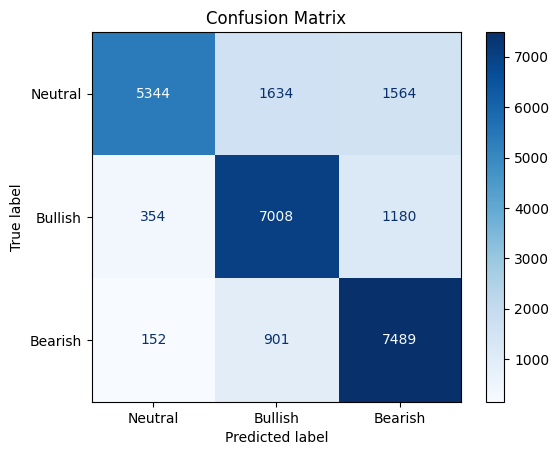


Classification Report:
              precision    recall  f1-score   support

     Neutral     0.9135    0.6256    0.7426      8542
     Bullish     0.7344    0.8204    0.7750      8542
     Bearish     0.7318    0.8767    0.7978      8542

    accuracy                         0.7743     25626
   macro avg     0.7932    0.7743    0.7718     25626
weighted avg     0.7932    0.7743    0.7718     25626



In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report ,confusion_matrix, ConfusionMatrixDisplay
# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Validate the model
val_loss, val_accuracy, predictions, labels = validate_model(model, validation_loader1, criterion, "cuda")

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

cm = confusion_matrix(labels, predictions)
classes = ["Neutral", "Bullish", "Bearish"]  # Replace with your actual class names

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

report = classification_report(labels, predictions, target_names=classes, digits=4)
print("\nClassification Report:")
print(report)